In [1]:
#-------------------------------
# General Analysis Settings

# basepath: This defines the base directory for storing all the generated analysis files. 
# It should have at least 10-20 GB free. 
basepath = '/data/GCE_sys/'

# tag: All the generated files carry this tag. Should be descriptive of analysis.
tag = 'P8R2_PSF1_CLEAN_V6_calore' 

#--------------------------------
# Energy Binning Settings
# The energy binning by default matches that of Calore et al 2014 (see 1409.0042 Eq.2 and discussion)
# This consists of a few linear spaced bins at low energies followed by a rescursive binning definition.
# If custom binning is required, just set the bin edges using prefix_bins=... and change n_bins=0
prefix_bins=[300, 350, 400, 450, 500] # Fixed bins go here and are prepended to any additional recursive bins
# These 4 settings are for recursive bin definitions.  To disable set n_bins=0
n_bins = 20 # number of recursive bins
E_min = 5e2 # Starting recusrion energy
E_max = 5e5 # Max recursion energy
gamma = 1.45 # Recursion index. 

#--------------------------------
# Spatial Binning
healpix_order = 8 # Healpix order.  8 gives ~0.24 degree pixel edge width.  Increase of 1 halves the bin size.

#--------------------------------
# Fermitools settings

# phfile input to gtselect. Can be merged photon file or a text file containing paths of each weekly file
#phfile_raw = '/data/fermi_data_1-8-14/phfile.txt' 
phfile_raw = '/data/fermi_data_6-26-15/phfile.txt' 


# scfile [filename]
#           Spacecraft data file containing information such as the spacecraft
#           pointing as a function of time. This file could be generated by
#           gtorbsim for simulated observations (see the gtorbsim help for further
#           explanation) or it can be obtained from the FERMI
#           Science Support Center (FSSC) website for real observations.
scfile = '/data/fermi_data_1-8-14/lat_spacecraft_merged.fits' # Path to spacecraft file


# (evclass) [integer] 
#          Event class selection for pass 7 reprocessed data. The 
#          default is 2 (source class). Other values are 0 for transient
#          data, 3 for the clean data class and 4 for the ultraclean data
#          class. 1 is currently unused. 
#evclass = 3 # FermiTools evclass
evclass = 256 # FermiTools evclass
evtype='8'

#     (convtype) [integer]
#          Conversion type. This parameter screens events based on which
#          portion of the instrument the incident gamma-ray pair conversion
#          event occurred. 0=Front, 1=Back, -1=both (defalt value). Refer 
#          to the Cicerone manual for details
#          (http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone).
convtype = -1

# filter [string]
#           This is the filter expression. The cuts are make using C-style
#           relational syntax like for example: ! (not), && (and), || (or), !=
#           (different), >, <, >=, <=, abs(), cos(), sin(), etc. Default is 
#           "DATA_QUAL>0 && LAT_CONFIG==1 && ABS(ROCK_ANGLE)<52".

gtfilter = 'DATA_QUAL>0 && LAT_CONFIG==1 && ABS(ROCK_ANGLE)<52' # gtmktime cut

# The fermi instrument response function.  Can get full list via command gtirfs
# ******MAKE SURE THIS MATCHES evclass and convtype above!************
# Some common ones....
# P7REP_CLEAN_V15 ( = P7REP_CLEAN_V15::FRONT + P7REP_CLEAN_V15::BACK )
# P7REP_CLEAN_V15::BACK
# P7REP_CLEAN_V15::FRONT
# P7REP_SOURCE_V15 ( = P7REP_SOURCE_V15::FRONT + P7REP_SOURCE_V15::BACK )
# P7REP_SOURCE_V15::BACK
# P7REP_SOURCE_V15::FRONT
# P7REP_ULTRACLEAN_V15 ( = P7REP_ULTRACLEAN_V15::FRONT + P7REP_ULTRACLEAN_V15::BACK )
# P7REP_ULTRACLEAN_V15::BACK
# P7REP_ULTRACLEAN_V15::FRONT
#irf = 'P7REP_CLEAN_V15' 
irf = 'P8R2_CLEAN_V6::PSF1' 


# zmax [double]
#          Maximum apparent zenith angle (degrees). It ranges from 0 to 180 (default).
zmax = 90  # Max zenith angle cut

#---------------------------------------------------------
# Some file paths containing fermi data. 

# path to 3FGL file (or 2FGL)
# can download this at http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/gll_psc_v14.fit
#      (2FGL is at at: http://fermi.gsfc.nasa.gov/ssc/data/access/lat/2yr_catalog/gll_psc_v08.fit)
fglpath = '/data/gll_psc_v16.fit' # 
#fglpath = '/data/gll_psc_v08.fit' # 

# Path to a fermi diffuse model.  Used only to calculate point source masking per Calore et al.
# Can get this at http://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html
#path_to_diffuse_model = '/home/carlson/fermitools/refdata/fermi/galdiffuse/gll_iem_v05.fits'
path_to_diffuse_model = '/data/fermi_background_models/gll_iem_v06.fits'




#---------------------------------------------------------
# Run this thing....
from Analysis import Analysis

A = Analysis( E_min, E_max, 2**healpix_order, gamma, n_bins, prefix_bins, tag, basepath, phfile_raw,
                    scfile, evclass, convtype,  zmax, irf, fglpath, gtfilter, '/data/Extended_archive_v15/Templates/', evtype,)

A.GenFermiData(runscript=True)
A.GenExposureMap()

#------------------------------------------------------------------------
# Extended source template
A.PopulateROI([0,0],radius=360, fix_radius=360, include_point=False)
master = np.zeros(A.templateList['W51C'].healpixCube.shape)
for key, t in A.templateList.items():
    master += t.healpixCube.toarray()
#------------------------------------------------------------------------

A.GenPointSourceTemplate(pscmap=(A.basepath + '/PSC_' + A.tag + '_fgl3.npy'))

master += np.load(A.basepath + '/PSC_' + A.tag + '_fgl3.npy')
np.save(A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy', master)

A.BinPhotons(outfile='binned_photons_'+A.tag+'.npy')

A.AddFermiDiffuseModel(diffuse_path=path_to_diffuse_model,
                       outfile='fermi_diffuse_'+A.tag+'.npy', multiplier=1.)

Run this script to generate the required fermitools files for this analysis.
The script can be found at /data/GCE_sys//GenFermiData_P8R2_PSF1_CLEAN_V6_calore_.sh
Get a beer. This will take a while...
running gtselect
running gtbindef
This is gtbindef version ScienceTools-v10r0p5-fssc-20150518
running gtpsf
running gtbin
This is gtbin version ScienceTools-v10r0p5-fssc-20150518
running gtexpcube2


Computing binned exposure map....................!

Populating ROI with point sources: 123 of 3034
Populating ROI with point sources: 603 of 3034
Populating ROI with point sources: 640 of 3034
Populating ROI with point sources: 697 of 3034
Populating ROI with point sources: 930 of 3034
Populating ROI with point sources: 956 of 3034
Populating ROI with point sources: 1001 of 3034
Populating ROI with point sources: 1568 of 3034
Populating ROI with point sources: 1624 of 3034
Populating ROI with point sources: 1848 of 3034
Populating ROI with point sources: 1963 of 3034
Populating ROI with point 

In [12]:
# master += np.load(A.basepath + '/PSC_' + A.tag + '_fgl3.npy')
# np.save(A.basepath + '/PSC_' + A.tag + '_fgl3_with_ext.npy', master)

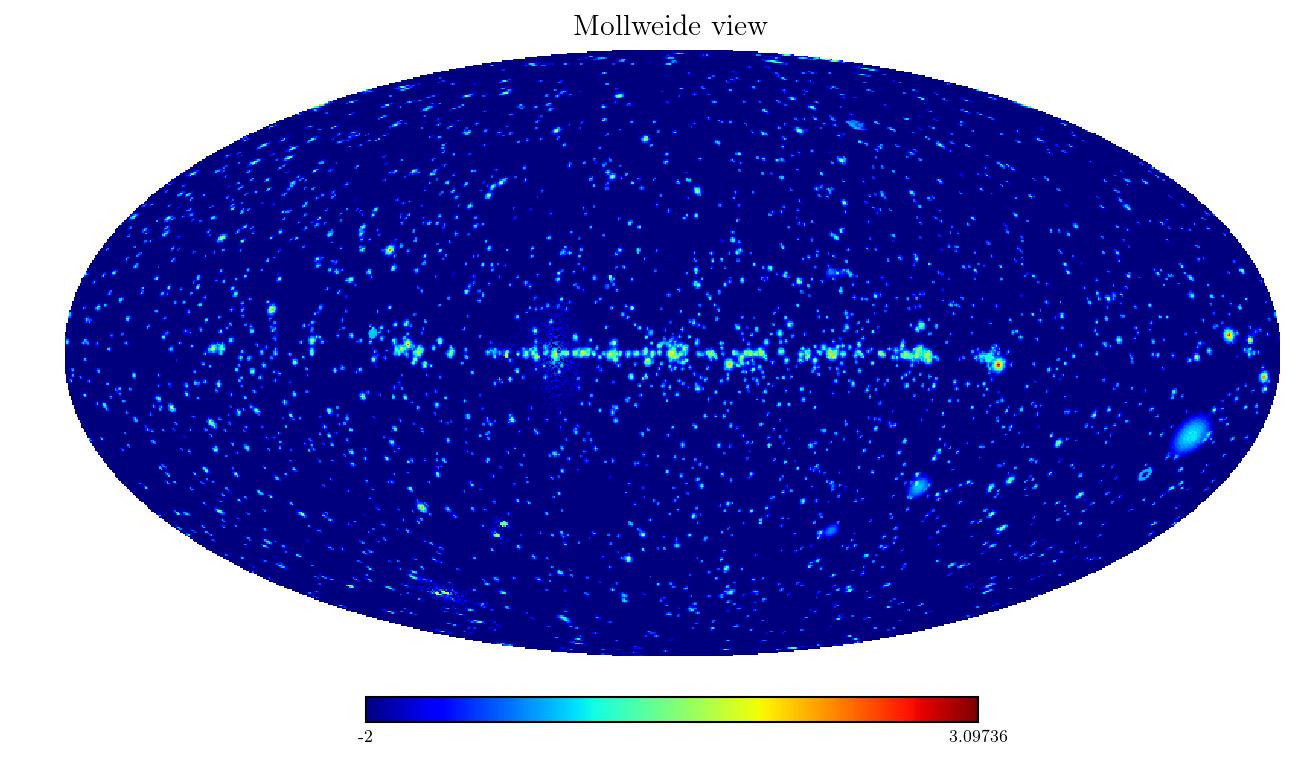

In [4]:
import healpy
healpy.mollview(np.log10(master[16]),min=-2)

In [2]:
psc = A.GenPointSourceTemplate(pscmap=(A.basepath + '/PSC_' + A.tag + '_fgl3.npy'))

Generating Point Source Map: 0.59 %

KeyboardInterrupt: 

In [ ]:
healpy.cartview(np.log10(psc[0]))

In [ ]:
A.PopulateROI(in)